In [1]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import random
import networkx as nx

In [2]:
#Load the cleaned dataset. The Cleaning of the dataset is done in clean_data.ipynb
df_test = pd.read_csv("./data_10k.csv", sep=',')

In [3]:
#Print the shape of the dataframe, to check the number of recipes and ingredients
print(df_test.shape)

(10000, 9663)


In [4]:
df = df_test.set_index("id")

In [5]:
a = pd.DataFrame(df.sum()).sort_values(by=0, ascending=False)
b = pd.DataFrame(df.sum(axis=1)).sort_values(by=0, ascending=False)

In [6]:
translation_recipe_id_index = df_test['id'].reset_index().set_index('id').to_dict()['index']

In [7]:
# Salt and pepper are often scrapped as only one ingredient
df['pepper'] = df['pepper'] + df['ground pepper']
df['pepper'] = df['pepper'] + df['salt pepper']
df['salt'] = df['salt'] + df['salt pepper']
df['salt'] = df['salt'].clip(0,1)
df['pepper'] = df['pepper'].clip(0,1)

In [8]:
#We delete ingredients presents only once, as they probably are outliers
columns = a[a[0] > 1].index.values
drop_columns = ["salt ground pepper", "half", "salt pepper", "ground pepper"]
cols = np.setdiff1d(columns, drop_columns)
df_clean = df[cols]

In [9]:
df_clean.shape

(10000, 2754)

In [10]:
df_clean.isnull().sum().sum()

0

In [11]:
df_clean.head()

2-percent yogurt  aburaage  accompaniment lemon wedge  adobo  \
id                                                                         
6a90237a1f               0.0       0.0                        0.0    0.0   
f3234317a4               0.0       0.0                        0.0    0.0   
fe207a8ce1               0.0       0.0                        0.0    0.0   
ebd602ad45               0.0       0.0                        0.0    0.0   
f38f4ee25d               0.0       0.0                        0.0    0.0   

            adobo sauce  agave nectar  ahi tuna  ale  alfredo sauce  allspice  \
id                                                                              
6a90237a1f          0.0           0.0       0.0  0.0            0.0       0.0   
f3234317a4          0.0           0.0       0.0  0.0            0.0       0.0   
fe207a8ce1          0.0           0.0       0.0  0.0            0.0       0.0   
ebd602ad45          0.0           0.0       0.0  0.0            0.0       0.0   
f38f4ee25d          0.0           0.0       0.0  0.0            0.0       0.0   

            ...  yukon gold potato  yukon gold potato chunk  yuzu juice  zest  \
id          ...                                                                 
6a90237a1f  ...                0.0                      0.0         0.0   0.0   
f3234317a4  ...                0.0                      0.0         0.0   0.0   
fe207a8ce1  ...                0.0                      0.0         0.0   0.0   
ebd602ad45  ...                0.0                      0.0         0.0   0.0   
f38f4ee25d  ...                0.0                      0.0         0.0   0.0   

            zesty  ziti pasta  zucchini  zucchini chunk  zucchini piece  \
id                                                                        
6a90237a1f    0.0         0.0       0.0             0.0             0.0   
f3234317a4    0.0         0.0       0.0             0.0             0.0   
fe207a8ce1    0.0         0.0       0.0             0.0             0.0   
ebd602ad45    0.0         0.0       0.0             0.0             0.0   
f38f4ee25d    0.0         0.0       0.0             0.0             0.0   

            zucchini summer squash  
id                                  
6a90237a1f                     0.0  
f3234317a4                     0.0  
fe207a8ce1                     0.0  
ebd602ad45                     0.0  
f38f4ee25d                     0.0  

[5 rows x 2754 columns]

In [12]:
Sortedingredients = pd.DataFrame(df_clean.sum()).sort_values(by=0, ascending=False)
Sortedingredients[Sortedingredients[0] > 1][:10]

0
salt       4527.0
pepper     3176.0
sugar      3081.0
onion      2819.0
egg        2282.0
butter     2229.0
flour      1999.0
water      1753.0
milk       1456.0
olive oil  1456.0

In [13]:
features = df_clean.values
features.shape

(10000, 2754)

In [14]:
def compute_matrixconnectivity(features):
    nbingredients=features.shape[1]
    nbrecettes=features.shape[0]
    connectivityingredients=np.zeros((nbingredients, nbingredients))
    for i in range(nbrecettes):
        a=features[i]!=0
        listindexingredients=[j for j, x in enumerate(a) if x]
        for pair in itertools.product(listindexingredients, repeat=2):
            connectivityingredients[pair[0], pair[1]] = connectivityingredients[pair[0], pair[1]]+1
    for j in range(nbingredients):
        connectivityingredients[j,j]=0
    return(connectivityingredients)

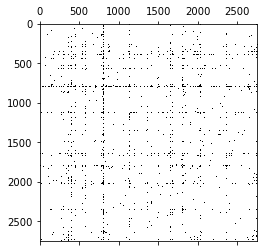

In [15]:
matrixconnectivity=compute_matrixconnectivity(features)
plt.spy(matrixconnectivity)
nbingredients=features.shape[1]
nbrecettes=features.shape[0]

In [16]:
meanconnectioningredients=matrixconnectivity.mean()
maxconnectivity=np.max(matrixconnectivity)
print("max connectivity : ", maxconnectivity)
print("mean connection : ", meanconnectioningredients, "\n")

print("Connexion ranking:")
mostconnexions=np.sort(matrixconnectivity.flatten())[-20:]
mostconnexions=[j for i,j in enumerate(mostconnexions) if i%2==0]
for i in range(len(mostconnexions)):
    index=np.where(matrixconnectivity==mostconnexions[len(mostconnexions)-1-i])
    print(df_clean.columns[index[0][0]], df_clean.columns[index[1][0]], mostconnexions[len(mostconnexions)-1-i])




max connectivity :  2448.0
mean connection :  0.08306265027326727 

Connexion ranking:
pepper salt 2448.0
onion salt 1579.0
salt sugar 1531.0
onion pepper 1529.0
flour salt 1383.0
egg salt 1300.0
egg sugar 1269.0
butter salt 1240.0
flour sugar 1216.0
egg flour 1090.0


2448.0


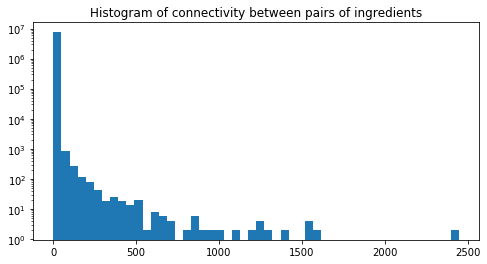

In [17]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of connectivity between pairs of ingredients")
plt.hist(matrixconnectivity.flatten(), log=True, bins=50)
print(matrixconnectivity.max())

2448.0


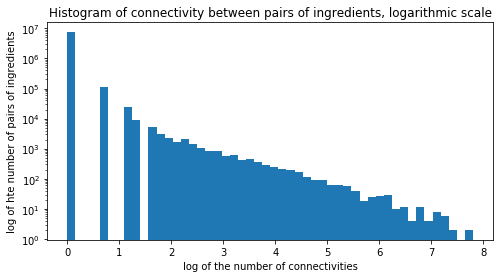

In [18]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of connectivity between pairs of ingredients, logarithmic scale")
plt.hist(np.log(matrixconnectivity.flatten()+1), log=True, bins=50)
plt.xlabel("log of the number of connectivities")
plt.ylabel("log of hte number of pairs of ingredients")
print(matrixconnectivity.max())

In [19]:
def make_A_feature(connectivity, threshold, lower_threshold=0):
    A_feature = ((threshold <= connectivity)).astype(int)
    np.fill_diagonal(A_feature, 0)
    return A_feature

def cleanAfeature(A):
    cleaned=A.copy()
    deleted=0
    for i in range (len(A)):
        if sum( A[len(A)-1-i] )==0:
            deleted+=1
            #print(i)
            cleaned=np.delete(cleaned,len(A_feature)-1-i , 0)
            cleaned=np.delete(cleaned,len(A_feature)-1-i, 1)
    #print("deleted", deleted)
    return(cleaned)

Number of edges :  14562
Number of non connexions :  7566848
nb colonnes A_feature :  2754
nb colonnes A_feature_cleaned :  818


''

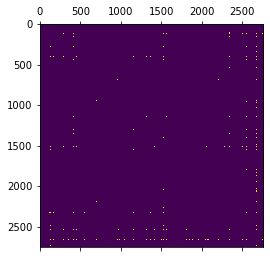

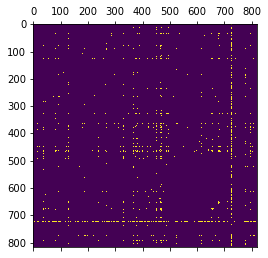

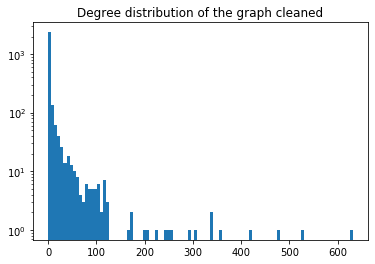

In [20]:
Threshold=5
print( "Number of edges : " , sum(sum(matrixconnectivity>Threshold)))
print( "Number of non connexions : " ,sum(sum(matrixconnectivity<Threshold)))

A_feature = make_A_feature(matrixconnectivity, Threshold)
A_featurecleaned= cleanAfeature(A_feature)

print('nb colonnes A_feature : ', len(A_feature))
print('nb colonnes A_feature_cleaned : ', len(A_featurecleaned))

plt.matshow(A_feature)
plt.matshow(A_featurecleaned)
plt.figure()
plt.hist(sum(A_feature), log=True, bins=100)
plt.title('Degree distribution of the graph cleaned')
""

In [ ]:
#Computation of the number of components

In [40]:
G_citation = nx.from_numpy_matrix(A_feature)
G_citatio = nx.from_numpy_matrix(A_featurecleaned)
print('Number of nodes: {}, Number of edges: {}'. format(G_citation.number_of_nodes(), G_citation.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_citation.number_of_selfloops(), nx.number_connected_components(G_citation)))
print('Number of nodes: {}, Number of edges: {}'. format(G_citatio.number_of_nodes(), G_citatio.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_citatio.number_of_selfloops(), nx.number_connected_components(G_citatio)))
print(f"Diameter according to networkx: {nx.diameter(G_citatio)}")

Number of nodes: 2754, Number of edges: 8834
Number of self-loops: 0, Number of connected components: 1937
Number of nodes: 818, Number of edges: 8834
Number of self-loops: 0, Number of connected components: 1
Diameter according to networkx: 4


Text(0.5, 1.0, 'Degree distribution of the cleaned graph')

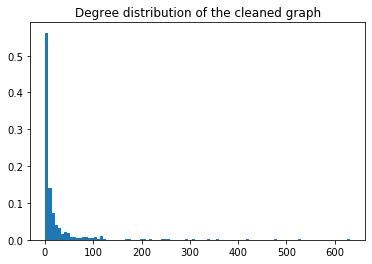

In [22]:
degrees_feature = A_featurecleaned.sum(1)

deg_hist_normalization = np.ones(degrees_feature.shape[0]) / degrees_feature.shape[0]

plt.hist(degrees_feature, weights=deg_hist_normalization, bins=100);
plt.title("Degree distribution of the cleaned graph")

Number of nodes: 806, Number of edges: 4467
Number of self-loops: 0, Number of connected components: 320


Text(0.5, 1.0, 'Degree distribution of the graph')

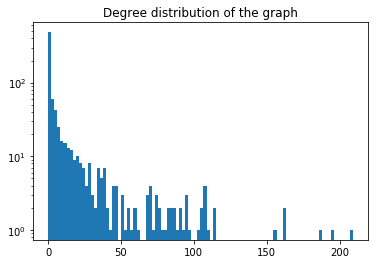

In [41]:
sort_feat = np.argsort(degrees_feature)
#print(len(degrees_feature))
#sort_cit = np.argsort(degrees_citation)

reduced_A_feature = A_featurecleaned[sort_feat[:-12],:][:, sort_feat[:-12]]
G_citat = nx.from_numpy_matrix(reduced_A_feature)
print('Number of nodes: {}, Number of edges: {}'. format(G_citat.number_of_nodes(), G_citat.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_citat.number_of_selfloops(), nx.number_connected_components(G_citat)))
plt.figure()
plt.hist(sum(reduced_A_feature), log=True, bins=100)
plt.title('Degree distribution of the graph')

In [23]:
degfs, counts_feat = np.unique(degrees_feature, return_counts=True)
degfeatprobs = counts_feat / counts_feat.sum()
feat_moment_1 = (degfs*degfeatprobs).sum()
feat_moment_2 = (degfs*degfs*degfeatprobs).sum()
print(f"1st moment of feature graph: {feat_moment_1}")
print(f"2nd moment of feature graph: {feat_moment_2}")

1st moment of feature graph: 21.599022004889978
2nd moment of feature graph: 3240.6136919315404


In [24]:
feature_graph = nx.from_numpy_matrix(A_featurecleaned)

In [25]:
def plot_graph(G, size=(30,30)):
    plt.figure(1,figsize=size) 
    nx.draw_networkx(G)
    plt.show()

C:\Users\Julien\Miniconda3\envs\ntds_2019\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


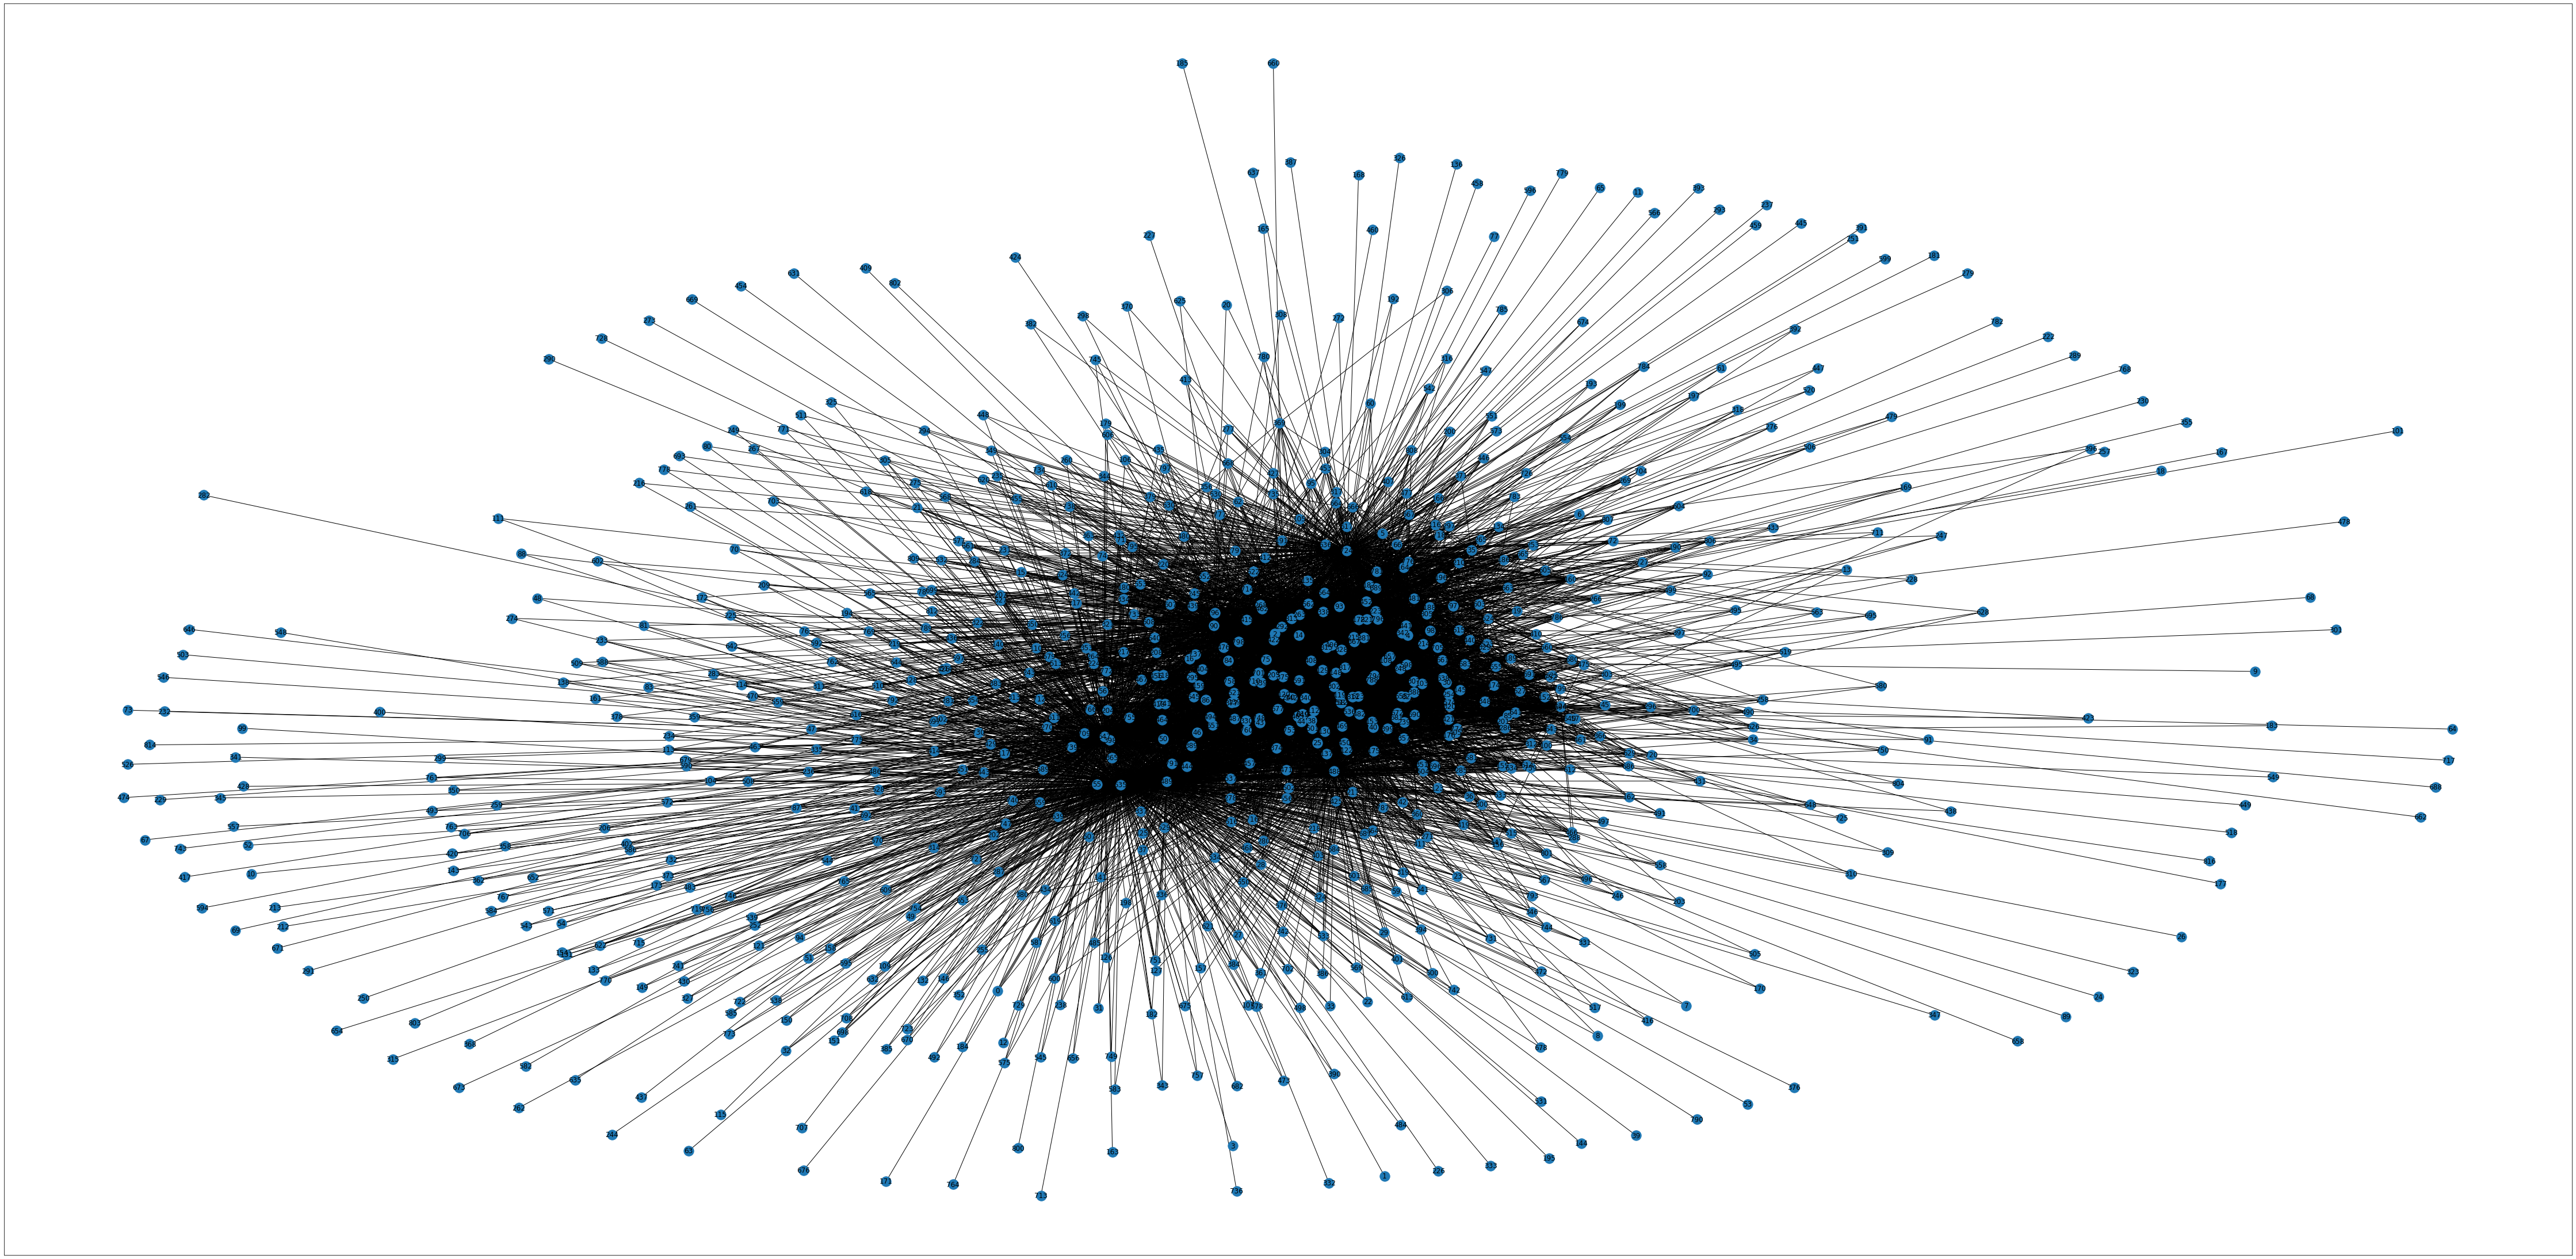

In [26]:
plot_graph(feature_graph, size=(80,40))

In [27]:
Cycle=nx.find_cycle(feature_graph, random.randint(0, len(A_featurecleaned)))
print(Cycle)

[(4, 5), (5, 90), (90, 2), (2, 14), (14, 4)]


In [28]:
for i in Cycle:
    print(df_clean.columns[i[0]])

adobo sauce
agave nectar
baby carrot
accompaniment lemon wedge
almond essence


## Creation of recipes


In [30]:
def create_new_recipe(index_ingredient, nbingredients):
    listneighbours=[]
    listingredients=[index_ingredient]
    maxiter=1000
    while(maxiter>0):
        choosen = random.choice(listingredients)
        a=(A_featurecleaned[choosen])
        #on regarde quels sont ses voisins
        listindneighbouringredients=[j for j, x in enumerate(a) if x]
        listneighbours=list(set(listneighbours+listindneighbouringredients))
        listingredients.append(random.choice(listneighbours))
        listingredients=list(set(listingredients))
        if len(listingredients)==nbingredients:
            maxiter=0
        else:
            maxiter-=1
    return listingredients

In [31]:
#Random recipes
listing=create_new_recipe(random.randint(0, len(A_featurecleaned)),5)
liste1=[]
for i in listing:
    liste1.append(df_clean.columns[i])
print(list(set(liste1)))

['chile', 'chorizo', 'cracker barrel tex mex cheese', 'cheese temperature', 'cinnamon ground']


In [32]:
#recipes containing a given element
Nameelement="avocado"
indexavocado=df_clean.columns.get_loc(Nameelement)
recipeavocado=create_new_recipe(indexavocado, 5)
liste=[]
for i in recipeavocado:
    liste.append(df_clean.columns[i])
print(liste)

['chipotle chile powder', 'chorizo', 'avocado', 'colby monterey jack cheese', 'cracker barrel tex mex cheese']


In [45]:
#Shortest path
import networkx as nx
feature_graph = nx.from_numpy_matrix(A_feature)

Nameelement1="cheese"
Nameelement2="milk"

indexelement1=df_clean.columns.get_loc(Nameelement1)
indexelement2=df_clean.columns.get_loc(Nameelement2)

path=nx.shortest_path(feature_graph, source=indexelement1, target=indexelement2, weight=None, method='dijkstra')

liste=[df_clean.columns[i] for i in path]
print(liste)

['cheese', 'milk']


## Comparison with existing recipes

In [34]:
def compute_dist_recipes(Recipe1, Recipe2):
    if len(Recipe1)==len(Recipe2):
        return(np.sqrt(sum( [ (Recipe1[i]-Recipe2[i])**2 for i in range(len(Recipe1)) ] )))
    else:
        print ("Recipes not the same size")
        return None

In [35]:
featurerecipes = df_clean.values

In [36]:
def formatrecipe(listingredients):
    Recipe=np.zeros(len(featurerecipes[0]))
    for i in listingredients:
        Recipe[i]=1
    return Recipe

In [42]:
listing1=create_new_recipe(random.randint(0, len(A_featurecleaned)), random.randint(2, 8))
liste=[]
for i in listing1:
    liste.append(df_clean.columns[i])
print(list(set(liste)))
Recette1=formatrecipe(listing1)

['beef sirloin steak strip', 'cheese herb', 'chicken raman noodle']


In [43]:
Mindist=5000
bestrecipe=[]

for i in range(len(featurerecipes)):
    dist=compute_dist_recipes(Recette1, featurerecipes[i])
    if dist<Mindist:
        Mindist=dist
        bestrecipe=featurerecipes[i]
        print(dist)
        print(sum(bestrecipe))
print(Mindist)
liste2=[]
for i in range(len(bestrecipe)):
    if bestrecipe[i]!=0:
        liste2.append(df_clean.columns[i])
print(list(set(liste2)))

2.8284271247461903
5.0
2.449489742783178
3.0
2.0
1.0
1.7320508075688772
0.0
1.7320508075688772
[]


In [44]:
Maxcommon=0
bestrecipe=[]
for i in range(len(featurerecipes)):
    a=sum([Recette1[j]*featurerecipes[i][j] for j in range(len(Recette1))])
    if Maxcommon<a:
        Maxcommon=a
        bestrecipe=featurerecipes[i]
print(Maxcommon)
for i in range(len(bestrecipe)):
    if bestrecipe[i]!=0:
        liste2.append(df_clean.columns[i])
print(list(set(liste2)))

1.0
['pepper', 'onion', 'sugar', 'cabbage', 'chicken raman noodle', 'vinegar', 'oil', 'seed', 'salt', 'almond']
